In [20]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import load_digits

In [21]:
# loading the datasets
import numpy as np
digits = load_digits()


In [22]:
 #selecting features and target
X = digits.data
Y = digits.target
Y_bin = label_binarize(Y, classes=np.unique(Y)) 


# splitting training and testing data (80% train and 20% test)
X_train, X_test, Y_train, Y_test, Y_bin_train, Y_bin_test = train_test_split(X, Y, Y_bin, test_size=0.2, random_state=72, shuffle=True)

# standardizing the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# defining the LDA model
model_lda = LinearDiscriminantAnalysis()
# fit the model
model_lda.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [26]:
# Predictions  
pred_lda = model_lda.predict(X_test)  
y_prob_lda = model_lda.predict_proba(X_test)  

# Evaluations  
bal_acc_lda = balanced_accuracy_score(Y_test, pred_lda)  
roc_lda = roc_auc_score(Y_test, y_prob_lda, multi_class="ovr", average="macro")  

print(f"LDA Balanced Accuracy: {bal_acc_lda:.4f}")  
print(f"LDA ROC-AUC Score: {roc_lda:.4f}")  


LDA Balanced Accuracy: 0.9457
LDA ROC-AUC Score: 0.9968


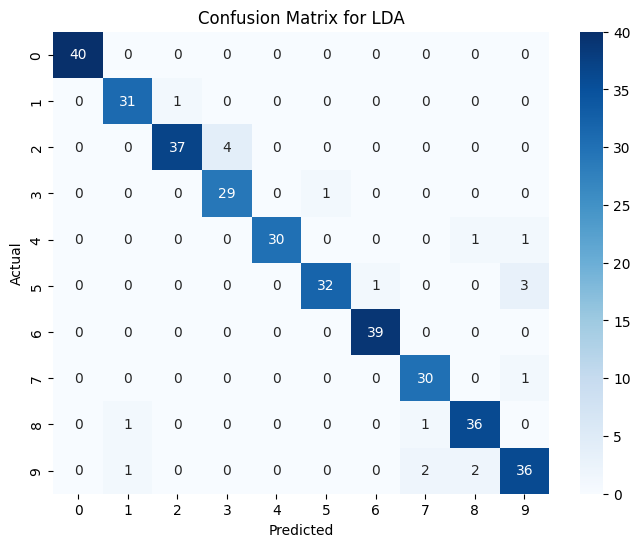

In [27]:
# Confusion Matrix  
plt.figure(figsize=(8, 6))  
sns.heatmap(confusion_matrix(Y_test, pred_lda), annot=True, fmt="d", cmap="Blues", xticklabels=digits.target_names, yticklabels=digits.target_names)  
plt.xlabel("Predicted")  
plt.ylabel("Actual")  
plt.title("Confusion Matrix for LDA")  
plt.show()  


In [23]:

# hyperparameter tuning using GridSearchCV
param_grid = [
    {"solver": ["svd"]},
    {"solver": ["lsqr", "eigen"], "shrinkage": ["auto"]}  # Including shrinkage parameter
]

# perform GridSearchCV for LDA model
grid_search_lda = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=5, scoring="balanced_accuracy", verbose=1)
grid_search_lda.fit(X_train, Y_train)

# best parameters
print(f"\nBest LDA Parameters: {grid_search_lda.best_params_}")

# get the best LDA model from GridSearchCV
best_lda = grid_search_lda.best_estimator_

# train the optimized LDA model
best_lda.fit(X_train, Y_train)

# predictions
pred_lda = best_lda.predict(X_test)
prob_lda = best_lda.predict_proba(X_test)

# evaluations
bal_acc_lda = balanced_accuracy_score(Y_test, pred_lda)
roc_lda = roc_auc_score(Y_bin_test, prob_lda, multi_class='ovr',average="macro")

print(f"LDA Balanced Accuracy: {bal_acc_lda:.4f}")
print(f"LDA ROC-AUC Score: {roc_lda:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best LDA Parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
LDA Balanced Accuracy: 0.9545
LDA ROC-AUC Score: 0.9972


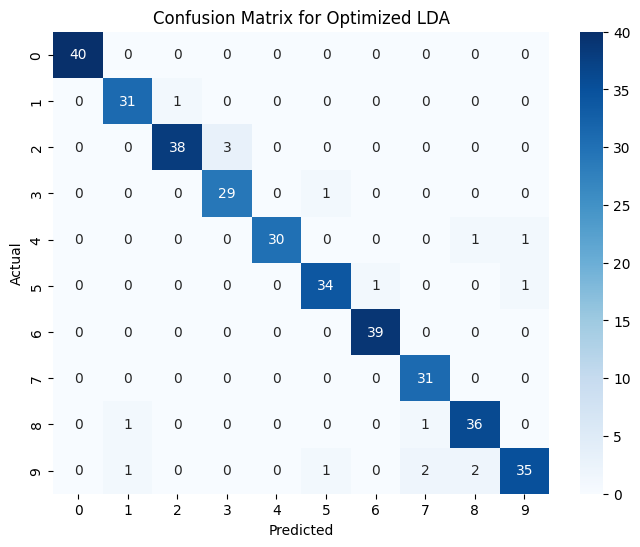

In [24]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, pred_lda), annot=True, fmt="d", cmap="Blues", xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Optimized LDA")
plt.show()


In [25]:
# evaluate performance using Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(Y_test, pred_lda))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.94      0.97      0.95        32
           2       0.97      0.93      0.95        41
           3       0.91      0.97      0.94        30
           4       1.00      0.94      0.97        32
           5       0.94      0.94      0.94        36
           6       0.97      1.00      0.99        39
           7       0.91      1.00      0.95        31
           8       0.92      0.95      0.94        38
           9       0.95      0.85      0.90        41

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360

